# Preparation #

In [1]:
# install CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6v4uawuw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6v4uawuw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=685b2077b9166f5ad1b453947d907713c8d5735b3d634c57754d857141d73618
  Stored in directory: /tmp/pip-ephem-wheel-cache-lhnrvsze/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup #

In [36]:
# library
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import transforms

import clip

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


# Preparing Model and Data

In [48]:
class ROOTDIR:
  train = "/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/roco-dataset/data/train/radiology/"
  val = "/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/roco-dataset/data/validation/radiology/"
  test = "/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/roco-dataset/data/test/radiology/"

In [49]:
# images
train_img = sorted(glob.glob(ROOTDIR.train+"images/*.jpg"))
val_img = sorted(glob.glob(ROOTDIR.val+"images/*.jpg"))

print(len(train_img), len(val_img))

1380 192


In [50]:
# image visualization function
def show(img_list, idx, loop=1):
  for i in range(loop):
    img_dir = os.path.join(img_list[i])
    img = Image.open(img_dir)
    print(f"image path: {img_list[i]}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

image path: /content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/roco-dataset/data/train/radiology/images/ROCO_00008.jpg


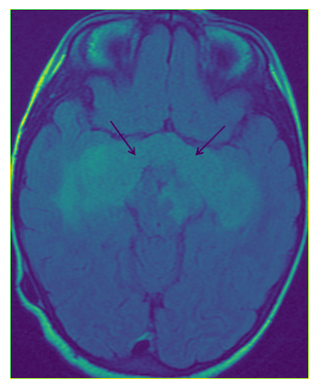

In [51]:
show(train_img, 0)

In [90]:
# labels
with open(ROOTDIR.train + "keywords.txt", "r") as f:
  train_labels = {}
  for line in f:
    fn, keywords = line.strip()[:10], line.strip()[12:]
    keywords = list(keywords.split())
    train_labels[fn] = keywords[:3]

In [75]:
model, preprocess = clip.load("ViT-B/32", device=device)

### Zero-Shot Prediction ###

In [91]:
labels = list(train_labels.values())
classes = []

for i in range(len(labels)):
  classes += labels[i]

In [92]:
image = preprocess(Image.open(train_img[0])).unsqueeze(0).to(device)
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

In [93]:
# calculate features
with torch.no_grad():
  image_features = model.encode_image(image)
  text_features = model.encode_text(text)

OutOfMemoryError: ignored